In [327]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

In [328]:
datastock = pd.read_csv('./000922.csv')  
#datastock = datastock.sort_values(by='Date').reset_index(drop=True)
datastock_all = datastock.filter(['Date'])
datastock_all['Before']=datastock.filter(['Before'])
datastock_set = datastock_all.iloc[:, 1:2].values #导入所有的上一交易日数据，相当于Close
training_data_len = int(np.ceil( len(datastock_set) * .95 )) #训练数据数量
print(training_data_len)
print(len(datastock_set))
#print(datastock_all.shape)
#print(datastock_set)
datastock_all.head()

4072
4286


,Date,Before
0,2005/1/4,1000.000
1,2005/1/5,981.555
2,2005/1/6,986.535
3,2005/1/7,975.526
4,2005/1/10,980.717


In [329]:
# 训练数据max-min归一化
from sklearn.preprocessing import MinMaxScaler
sc = MinMaxScaler(feature_range = (0, 1))
datastock_set_scaled = sc.fit_transform(datastock_set)

In [330]:
# 每条样本含60个时间步，对应下一时间步的标签值
train_data = datastock_set_scaled[0:int(training_data_len), :]
X_train = []
y_train = []
for i in range(60, len(train_data)):
    X_train.append(train_data[i-60:i, 0])
    y_train.append(train_data[i, 0])
X_train, y_train = np.array(X_train), np.array(y_train)

#print(X_train.shape)
#print(y_train.shape)
#print(X_train)
# Reshaping
X_train = np.reshape(X_train, (X_train.shape[0], X_train.shape[1], 1))
#print(X_train.shape)

In [331]:
#  利用Keras创建RNN模型

from keras.models import Sequential
from keras.layers import Dense
from keras.layers import SimpleRNN,LSTM
from keras.layers import Dropout

In [332]:
# 初始化顺序模型
regressor = Sequential()

# 定义输入层及带5个神经元的隐藏层
regressor.add(SimpleRNN(units = 5, input_shape = (X_train.shape[1], 1)))

# 定义线性的输出层
regressor.add(Dense(units = 1))

# 模型编译：定义优化算法adam， 目标函数均方根MSE
regressor.compile(optimizer = 'adam', loss = 'mean_squared_error')

Epoch 1/60
61/61 [==============================] - 1s 9ms/step - loss: 0.9410 - val_loss: 1.4425
Epoch 2/60
61/61 [==============================] - 0s 7ms/step - loss: 0.2943 - val_loss: 0.4281
Epoch 3/60
61/61 [==============================] - 0s 6ms/step - loss: 0.0926 - val_loss: 0.1792
Epoch 4/60
61/61 [==============================] - 0s 8ms/step - loss: 0.0534 - val_loss: 0.1007
Epoch 5/60
61/61 [==============================] - 0s 7ms/step - loss: 0.0362 - val_loss: 0.0635
Epoch 6/60
61/61 [==============================] - 0s 6ms/step - loss: 0.0249 - val_loss: 0.0432
Epoch 7/60
61/61 [==============================] - 0s 6ms/step - loss: 0.0184 - val_loss: 0.0321
Epoch 8/60
61/61 [==============================] - 0s 6ms/step - loss: 0.0152 - val_loss: 0.0255
Epoch 9/60
61/61 [==============================] - 0s 6ms/step - loss: 0.0138 - val_loss: 0.0224
Epoch 10/60
61/61 [==============================] - 0s 6ms/step - loss: 0.0127 - val_loss: 0.0201
Epoch 11/60
61/61 [

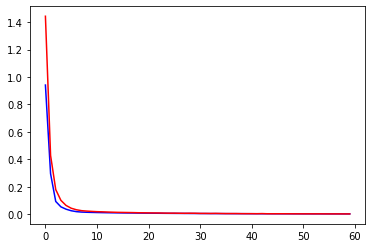

In [333]:
# 模型训练
history = regressor.fit(X_train, y_train, epochs = 100, batch_size = 100, validation_split=0.1)

regressor.summary()


plt.plot(history.history['loss'],c='blue')    # 蓝色线训练集损失
plt.plot(history.history['val_loss'],c='red') # 红色线验证集损失
plt.show()


In [348]:
# 测试数据
test_data = datastock_set_scaled[training_data_len - 60: , :]
#test_data = test_data.sort_values(by='Date').reset_index(drop=True)

X_test = []
Y_test = datastock_set[training_data_len:, :]
for i in range(60, len(test_data)):
    X_test.append(test_data[i-60:i, 0])
X_test = np.array(X_test)
X_test = np.reshape(X_test, (X_test.shape[0], X_test.shape[1], 1 ))

# 模型预测
predicted_stock_price = regressor.predict(X_test)
# 逆归一化
predicted_stock_price = sc.inverse_transform(predicted_stock_price)

#获得未来一天的预测，并能循环填写入测试集中 2022-5-02
last_predicted_stock_price = predicted_stock_price[len(predicted_stock_price)-1]
print(last_predicted_stock_price[0])

"""
#更新CSV现有最后一行的Before，并产生下一工作日的空记录
update_lastdata={'Date':['2022-04-30'],'Before':[last_predicted_stock_price.value]}
df = pd.DataFrame(update_lastdata,index=[len(datastock_all)])
df.to_csv('./000922.csv',mode='w',index=False,header=False)

new_data={'Date':['2022-05-01'],'Before':['']}
df = pd.DataFrame(new_data)
#mode = 'a'为追加数据，index为每行的索引序号，header为标题
df.to_csv('./000922.csv',mode='a',index=False,header=False)
"""

rmse = np.sqrt(np.mean(((predicted_stock_price - Y_test) ** 2)))

4465.242


C:\Users\frank_zhang\AppData\Local\Temp/ipykernel_37048/1741848046.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  valid['Predictions'] = predicted_stock_price


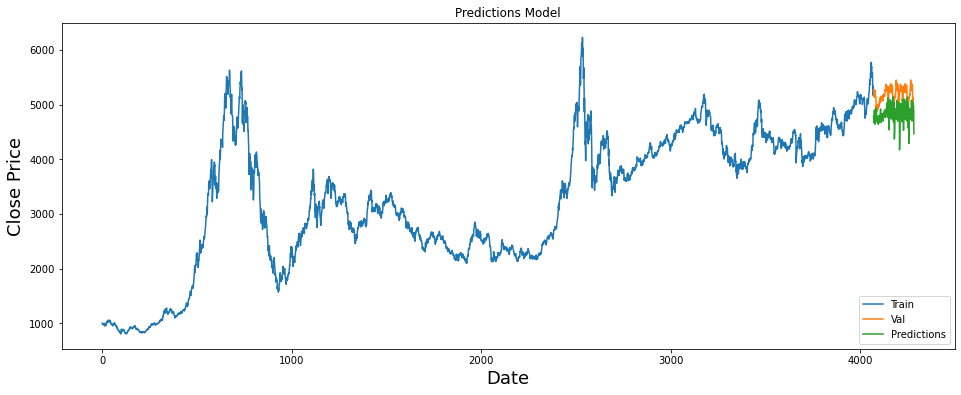

            Date     Before  Predictions
4072  2021/10/11  5244.4434  4784.325684
4073  2021/10/12  5275.2232  4683.797852
4074  2021/10/13  5187.6337  4667.033691
4075  2021/10/14  5151.1249  4809.296387
4076  2021/10/15  5130.9031  4899.378418
...          ...        ...          ...
4281   2022/4/26  4859.1573  4955.253418
4282   2022/4/27  4766.7064  4980.332520
4283   2022/4/28  4820.5909  4980.044922
4284   2022/4/29  4883.1703  4757.747070
4285   2022/4/30        NaN  4465.242188

[214 rows x 3 columns]


In [346]:
# 预测与实际差异的可视化

train = datastock_all[:training_data_len]
valid = datastock_all[training_data_len:]
valid['Predictions'] = predicted_stock_price
# Visualize the data
plt.figure(figsize=(16,6))
plt.title('Predictions Model')
plt.xlabel('Date', fontsize=18)
plt.ylabel('Close Price', fontsize=18)
plt.plot(train['Before'])
plt.plot(valid[['Before', 'Predictions']])
plt.legend(['Train', 'Val', 'Predictions'], loc='lower right')
plt.show()

print(valid)